## Introduction

## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt

import gym
import gym_solventx 

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
print(tf.__version__)

2.0.0


## Hyperparameters

In [10]:
env_name = "gym_solventx-v0" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,100,50)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 25  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

Load the environment as before, with one for training and one for evaluation. Here we use CartPole-v1 (vs. CartPole-v0 in the DQN tutorial), which has a larger max reward of 500 rather than 200.

In [3]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

C51 is a Q-learning algorithm based on DQN. Like DQN, it can be used on any environment with a discrete action space.

The main difference between C51 and DQN is that rather than simply predicting the Q-value for each state-action pair, C51 predicts a histogram model for the probability distribution of the Q-value:

![Example C51 Distribution](images/c51_distribution.png)

By learning the distribution rather than simply the expected value, the algorithm is able to stay more stable during training, leading to improved final performance. This is particularly true in situations with bimodal or even multimodal value distributions, where a single average does not provide an accurate picture.

In order to train on probability distributions rather than on values, C51 must perform some complex distributional computations in order to calculate its loss function. But don't worry, all of this is taken care of for you in TF-Agents!

To create a C51 Agent, we first need to create a `CategoricalQNetwork`. The API of the `CategoricalQNetwork` is the same as that of the `QNetwork`, except that there is an additional argument `num_atoms`. This represents the number of support points in our probability distribution estimates. (The above image includes 10 support points, each represented by a vertical blue bar.) As you can tell from the name, the default number of atoms is 51.



In [4]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

Note that one other significant difference from vanilla `DqnAgent` is that we now need to specify `min_q_value` and `max_q_value` as arguments. These specify the most extreme values of the support (in other words, the most extreme of the 51 atoms on either side). Make sure to choose these appropriately for your particular environment. Here we use -20 and 20.

In [5]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

One last thing to note is that we also added an argument to use n-step updates with $n$ = 2. In single-step Q-learning ($n$ = 1), we only compute the error between the Q-values at the current time step and the next time step using the single-step return (based on the Bellman optimality equation). The single-step return is defined as:

$G_t = R_{t + 1} + \gamma V(s_{t + 1})$

where we define $V(s) = \max_a{Q(s, a)}$.

N-step updates involve expanding the standard single-step return function $n$ times:

$G_t^n = R_{t + 1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^n V(s_{t + n})$

N-step updates enable the agent to bootstrap from further in the future, and with the right value of $n$, this often leads to faster learning.

Although C51 and n-step updates are often combined with prioritized replay to form the core of the [Rainbow agent](https://arxiv.org/pdf/1710.02298.pdf), we saw no measurable improvement from implementing prioritized replay. Moreover, we find that when combining our C51 agent with n-step updates alone, our agent performs as well as other Rainbow agents on the sample of Atari environments we've tested.

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [6]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

#compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

## Data Collection

As in the DQN tutorial, set up the replay buffer and the initial data collection with the random policy.

In [9]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for i in range(initial_collect_steps):
    print(i)
    collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

0
1
2
3
4
5
6


C:\Users\splathottam\.conda\envs\gym_simulator\lib\site-packages\scipy\optimize\nonlin.py:475: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280


In [12]:
next(iterator)

(Trajectory(step_type=<tf.Tensor: id=29515, shape=(64, 3), dtype=int32, numpy=
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

The following will take ~7 minutes to run.

In [13]:
#@test {"skip": true}
#%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

step = 25: loss = 0.16028697788715363
step = 50: loss = 0.17000138759613037


C:\Users\splathottam\.conda\envs\gym_simulator\lib\site-packages\scipy\optimize\nonlin.py:475: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


step = 75: loss = 0.12941479682922363
step = 100: loss = 0.0668918713927269
step = 125: loss = 0.00365733471699059
step = 150: loss = 0.0724501684308052
step = 175: loss = 0.011846370063722134
step = 200: loss = 0.015369021333754063
step = 225: loss = 0.004074460826814175
step = 250: loss = 0.13777358829975128
step = 275: loss = 0.0031425615306943655
step = 300: loss = 0.009174241684377193
step = 325: loss = 0.00722520612180233
step = 350: loss = 0.07669011503458023
step = 375: loss = 0.0679047629237175
step = 400: loss = 0.005140916910022497
step = 425: loss = 0.04810731112957001
step = 450: loss = 0.1225263774394989
step = 475: loss = 0.006990170571953058
step = 500: loss = 0.12083490937948227
step = 525: loss = 0.0073608895763754845
step = 550: loss = 0.004039769060909748
step = 575: loss = 0.062206756323575974
step = 600: loss = 0.03520073741674423
step = 625: loss = 0.007976322434842587
step = 650: loss = 0.0022611175663769245
step = 675: loss = 0.06574133783578873
step = 700: los

step = 5000: Average Return = -6671.47
step = 5025: loss = 0.06812111288309097
step = 5050: loss = 0.11946965754032135
step = 5075: loss = 0.018798358738422394
step = 5100: loss = 0.011560304090380669
step = 5125: loss = 0.010643796063959599
step = 5150: loss = 0.006489992141723633
step = 5175: loss = 0.040706850588321686
step = 5200: loss = 0.004066865425556898
step = 5225: loss = 0.009515754878520966
step = 5250: loss = 0.014009124599397182
step = 5275: loss = 0.005462448112666607
step = 5300: loss = 0.003895748872309923
step = 5325: loss = 0.011694632470607758
step = 5350: loss = 0.008766425773501396
step = 5375: loss = 0.003997023217380047
step = 5400: loss = 0.00822072010487318
step = 5425: loss = 0.007190256379544735
step = 5450: loss = 0.004354902543127537
step = 5475: loss = 0.21717087924480438
step = 5500: loss = 0.002996796276420355
step = 5525: loss = 0.005599659867584705
step = 5550: loss = 0.020398642867803574
step = 5575: loss = 0.14360332489013672
step = 5600: loss = 0.0

Epoch Failed!
step = 9875: loss = 0.11926648020744324
step = 9900: loss = 0.01573614776134491
step = 9925: loss = 0.04951256141066551
step = 9950: loss = 0.0020991340279579163
step = 9975: loss = 0.0012989749666303396
[True, True, True, False, True, True, True, True, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
step = 10000: loss = 0.005769754759967327
[True, True, True, False, True, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
[True, True, True, False, True, True, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
[True, True, True, False, True, True, True, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
[True, True, True, False, True, True, True, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
[True, True, True, False, True, True, True, True, True, True, True, True, True, True]
Equilibrium Failed! I

step = 10575: loss = 0.12599144876003265
step = 10600: loss = 0.2003866583108902
step = 10625: loss = 0.10821938514709473
step = 10650: loss = 0.07372990250587463
step = 10675: loss = 0.13392683863639832
step = 10700: loss = 0.07629528641700745
step = 10725: loss = 0.08680525422096252
step = 10750: loss = 0.04924719035625458
step = 10775: loss = 0.04744254797697067
step = 10800: loss = 0.06589168310165405
step = 10825: loss = 0.011920892633497715
step = 10850: loss = 0.026222866028547287
step = 10875: loss = 0.08235630393028259
[True, True, True, True, False, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
[True, True, True, True, False, True, True, True, True, True, True, True, True]
Equilibrium Failed! Invalid State Reached!
step = 10900: loss = 0.018795037642121315
step = 10925: loss = 0.02616961859166622
step = 10950: loss = 0.06235100328922272
step = 10975: loss = 0.18317431211471558
step = 11000: loss = 0.020461346954107285


C:\Users\splathottam\.conda\envs\gym_simulator\lib\site-packages\scipy\optimize\linesearch.py:711: RuntimeWarning: invalid value encountered in double_scalars
  alpha2 = (-b + np.sqrt(abs(b**2 - 3 * a * derphi0))) / (3.0*a)


step = 11000: Average Return = -5758.80
step = 11025: loss = 0.05469789355993271
step = 11050: loss = 0.033082686364650726
step = 11075: loss = 0.0375412181019783
step = 11100: loss = 0.02889394387602806
step = 11125: loss = 0.1186695545911789
step = 11150: loss = 0.11857697367668152
step = 11175: loss = 0.05395786464214325
step = 11200: loss = 0.023146428167819977
step = 11225: loss = 0.028384637087583542
step = 11250: loss = 0.13244414329528809
step = 11275: loss = 0.12826424837112427
step = 11300: loss = 0.005163517780601978
step = 11325: loss = 0.007408432196825743
step = 11350: loss = 0.09879369288682938
step = 11375: loss = 0.05789566785097122
step = 11400: loss = 0.09281739592552185
step = 11425: loss = 0.018958017230033875
step = 11450: loss = 0.12496282905340195
step = 11475: loss = 0.08919675648212433
step = 11500: loss = 0.015369392931461334
step = 11525: loss = 0.04276541620492935
step = 11550: loss = 0.12305134534835815
step = 11575: loss = 0.15409275889396667
step = 11600

## Visualization



### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v1`, the environment gives a reward of +1 for every time step the pole stays up, and since the maximum number of steps is 500, the maximum possible return is also 500.

(-7836.11650390625, 550)

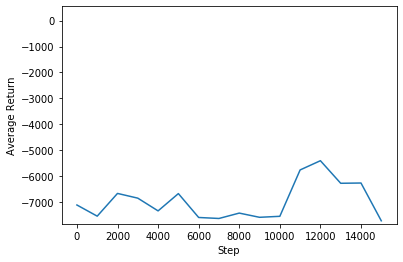

In [14]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

The following code visualizes the agent's policy for a few episodes:

In [ ]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

C51 tends to do slightly better than DQN on CartPole-v1, but the difference between the two agents becomes more and more significant in increasingly complex environments. For example, on the full Atari 2600 benchmark, C51 demonstrates a mean score improvement of 126% over DQN after normalizing with respect to a random agent. Additional improvements can be gained by including n-step updates.

For a deeper dive into the C51 algorithm, see [A Distributional Perspective on Reinforcement Learning (2017)](https://arxiv.org/pdf/1707.06887.pdf).